In [7]:
library(MASS)
library(RPostgreSQL)
con = dbConnect(dbDriver("PostgreSQL"), dbname = "nyc-taxi-data")
query = function(sql) { fetch(dbSendQuery(con, sql), n = 1e8) }
library(ggplot2)
library(ggmap)
library(plyr)
library(dplyr)
library(reshape2)
library(zoo)
library(scales)
library(extrafont)
#library(grid)
library(rgdal)
library(maptools)
tracts = spTransform(readOGR("../nyc-taxi-data/nyct2010_15b", layer = "nyct2010"), CRS("+proj=longlat +datum=WGS84"))
tracts@data$id = as.character(as.numeric(rownames(tracts@data)) + 1)
tracts.points = fortify(tracts, region = "id")
tracts.map = inner_join(tracts.points, tracts@data, by = "id")
manhattan_map = filter(tracts.map, BoroName == "Manhattan")
library(raster)
rrt_map = get_googlemap(center = c(-73.9888656, 40.7590577), zoom = 12, style = "feature:poi|visibility:off")

OGR data source with driver: ESRI Shapefile 
Source: "../nyc-taxi-data/nyct2010_15b", layer: "nyct2010"
with 2166 features
It has 11 fields


Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=40.759058,-73.988866&zoom=12&size=640x640&scale=2&maptype=terrain&style=feature:poi%7Cvisibility:off&sensor=false


In [25]:
pickups = query("SELECT * FROM ambassador_theatre_pickups_by_lat_lon_hour_weather WHERE weather_condition='bad_weather' AND avg_tip_amount>2.30")

In [24]:
summary(pickups$avg_tip_amount)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.010   1.900   2.300   3.015   3.250 126.000 

In [18]:
theatres = query("SELECT * from custom_locations LIMIT 5")

png 
  2

Warning message:
“`panel.margin` is deprecated. Please use `panel.spacing` property instead”Warning message:
“Removed 1271 rows containing missing values (geom_point).”

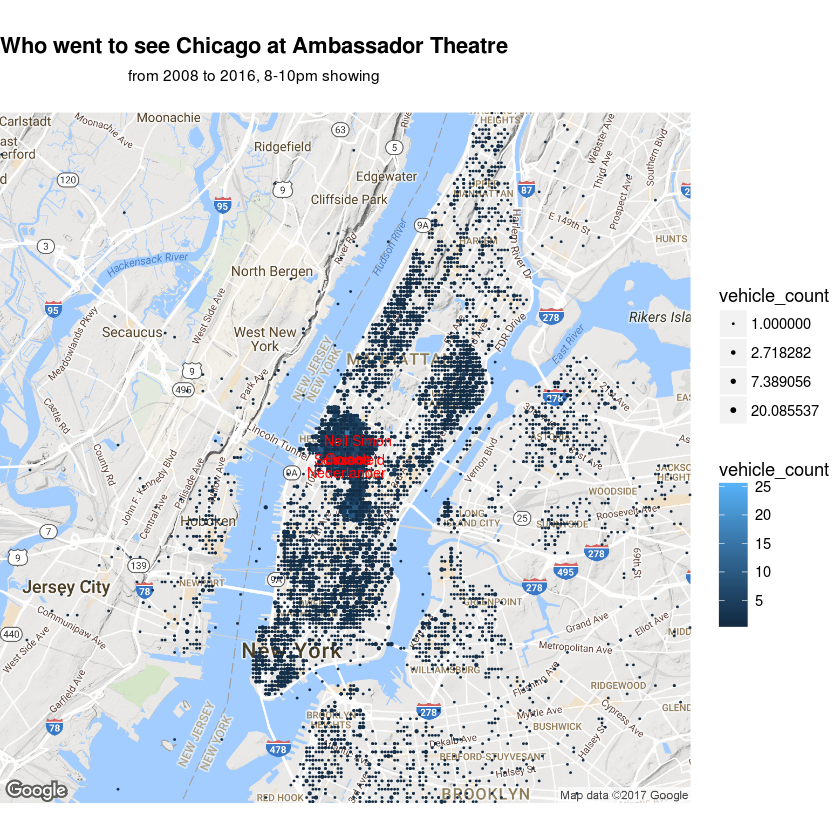

In [27]:
title_with_subtitle = function(title, subtitle = "") {
  ggtitle(bquote(atop(bold(.(title)), atop(.(subtitle)))))
}

alpha_range = c(0.14, 1)
size_range = c(0.134, 1)
png("taxi2.png", width = 640, height = 900, bg = "#f4f4f4")
dev.off()
p=ggmap(rrt_map, extent = "device") + 
geom_point(data=pickups,
              aes(x = dropoff_lon, y = dropoff_lat, size = vehicle_count, color=vehicle_count))+
  scale_size_continuous(range = alpha_range, trans = "log", limits = range(pickups$vehicle_count)) +
  title_with_subtitle("Who went to see Chicago at Ambassador Theatre", "from 2008 to 2016, 8-10pm showing")
p = p+geom_text(data = theatres, aes(x = lon, y = lat, label = name), 
          size = 3, vjust = "center", hjust = "center",color = "red")
print(p)